##### Student Name: Nayem Alam
##### Student ID  : 260743549
##### Assignment 3

## Part 2.2 - Epipolar Geometry
    Q. 1,2,3,4,5,6,7,8

### a) Compute matching SIFT keypoints from a stereo image pair.

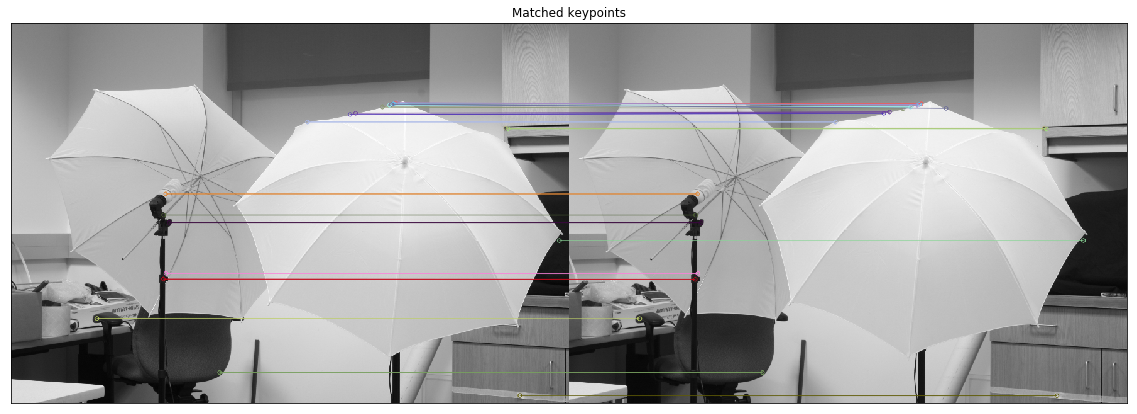

Number of matches:  20


In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from skimage import io

# load left and right images
imgL = cv2.imread("./im0.png", cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread("./im1.png", cv2.IMREAD_GRAYSCALE)

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# initiate SIFT, compute keypoints and descriptors
sift = cv2.xfeatures2d.SIFT_create()
keypointsL, descriptorsL = sift.detectAndCompute(imgL, None)
keypointsR, descriptorsR = sift.detectAndCompute(imgR, None)

# matching using brute force (taking the descriptor of one feature from first set to other features in second set)
bf = cv2.BFMatcher(cv2.NORM_L2)

# match descriptors (the best two for each)
matches = bf.match(descriptorsL,descriptorsR)

# sort in order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw 20 best matches
bestMatches = matches[:20]
imgMatch = cv2.drawMatches(imgL,keypointsL,imgR,keypointsR, bestMatches, imgL, flags=2)

plt.figure(figsize=(20,20))
plt.imshow(imgMatch)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

# to test
print("Number of matches: ",len(bestMatches))

### b) Compute and display the epipolar lines for both images.

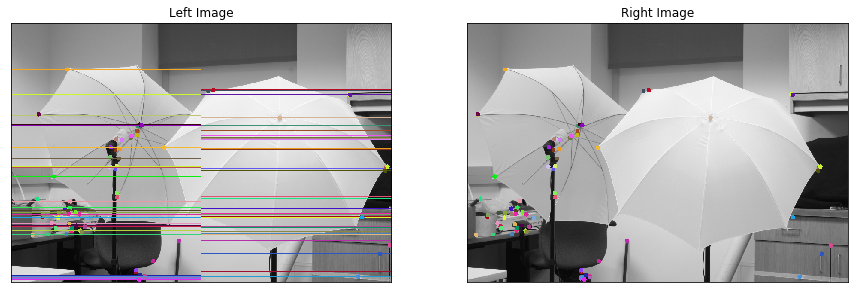

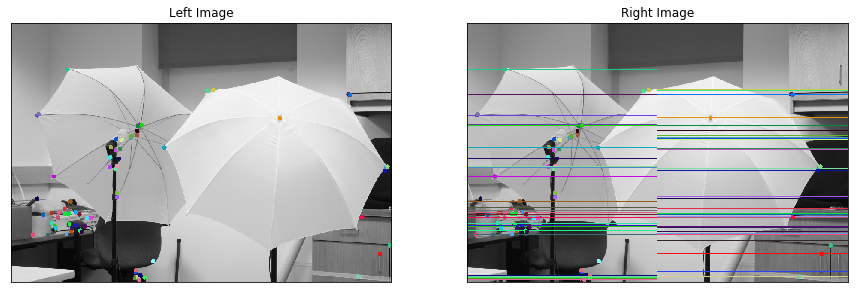

In [8]:
#  display epipolar lines - from tutorial notes
# and this helped understanding: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html 

listOriginal_kp1, listOriginal_kp2, list_kp1, list_kp2 = [],[],[],[]
""" drawlines """ 
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2


# brute force matching
bf2 = cv2.BFMatcher(cv2.NORM_L2)

# match descriptors (best two matches for each descriptor)
matches = bf2.knnMatch(descriptorsL, descriptorsR, k=2)

# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        # get coordinates
        ptsR.append(keypointsR[m.trainIdx].pt)
        ptsL.append(keypointsL[m.queryIdx].pt)
        
        # (x,y) coordinates for matching points
        listOriginal_kp1 = [keypointsL[m.queryIdx].pt for m in good] 
        listOriginal_kp2 = [keypointsR[m.queryIdx].pt for m in good] 
 
        
# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS)

# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linessL = linesL.reshape(-1, 3)
# draw lines
imgL1, imgR1 = drawlines(imgL, imgR, linessL, ptsL, ptsR)

linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(imgR, imgL, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

### c) Pick any one keypoint in the right image which doesn't have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 x 5) around this keypoint in the right image.

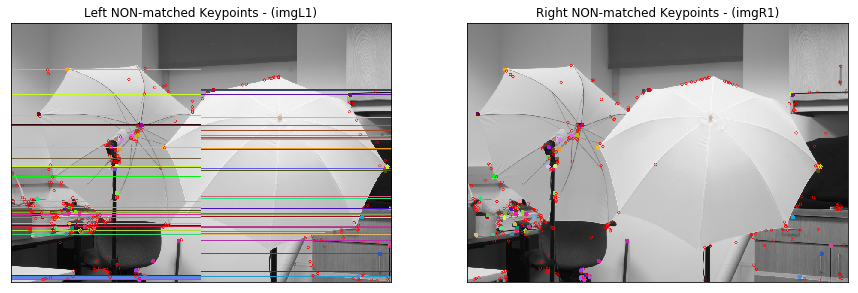

In [9]:
"""
SHOW ALL NON-MATCHING KEYPOINTS (not really required to show)
"""
#  find all non-matching keypoints (https://stackoverflow.com/questions/43775842/opencv-draw-non-matching-points)
keypointsL_matched=([ keypointsL[m.queryIdx] for m in good ])
keypointsR_matched=([ keypointsR[m.trainIdx] for m in good ])
# miss matched keypoints
keypointsL_miss_matched=[kp for kp in keypointsL if kp not in keypointsL_matched]
keypointsR_miss_matched=[kp for kp in keypointsR if kp not in keypointsR_matched]
# (x,y) coordinates for non-matching points
list_kp1 = [keypointsL[m.queryIdx].pt for kp in keypointsL if kp not in keypointsL_matched]
list_kp2 = [keypointsR[m.trainIdx].pt for kp in keypointsR if kp not in keypointsR_matched]
# draw only miss matched or not matched keypoints location
imgL1_miss_matched_kp = cv2.drawKeypoints(imgL1,keypointsL_miss_matched, None,color=(255,0,0), flags=0)
imgR1_miss_matched_kp = cv2.drawKeypoints(imgR1,keypointsR_miss_matched, None,color=(255,0,0), flags=0)
# display images
"""
NOTE: 
- the colored points = matching keypoints
- the red colored poitns = non-matching keypoints
"""
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1_miss_matched_kp, cmap="gray")
plt.title("Left NON-matched Keypoints - (imgL1)"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1_miss_matched_kp, cmap="gray")
plt.title("Right NON-matched Keypoints - (imgR1)"), plt.xticks([]), plt.yticks([])
plt.show()

Point being used: [105 493]
Check size: 5 x 5


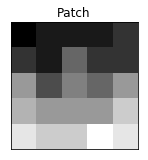

In [10]:
"""
EXTRACT A PATCH SIZE AT INDEX 22
"""
ptsL_bad = []
ptsR_bad = []
for i, (m, n) in enumerate(matches):
    # numbers chosen as per Lowe's ratio test
    if m.distance < 0.7 * n.distance and m.distance > 0.6 * n.distance:
        # (x,y) coordinates for non-matching points
        ptsR_bad.append(keypointsR[m.trainIdx].pt) 
        ptsL_bad.append(keypointsL[m.queryIdx].pt)
# print(ptsR_bad)
# print(ptsL_bad)
# select random point -> ptsR_bad[3]


# selected a random point in the right image which doesn't have a correct match in the left image (array 3)
randomPt = np.array(ptsR_bad[3]).astype(int) 
xP = randomPt[0]
yP = randomPt[1]
print("Point being used:",randomPt)
# print(imgL.shape)
# for me-if I need: my images shape: (605,888)

# extracting 5x5 patch using steps provided in: 
# https://stackoverflow.com/questions/31968588/extract-a-patch-from-an-image-given-patch-center-and-patch-scale?fbclid=IwAR0eHGC6LCEJ22iA3D6ve3rgEurUeNAKsdNQCjgZ4lcIprC1YSqIVuG5FXw
patch = imgR[xP-3:xP+2,yP-3:yP+2]
print("Check size:",patch.shape[0],"x",patch.shape[1])

# display patch 
plt.figure(figsize=(5,5))
plt.subplot(121), plt.imshow(patch, cmap="gray")
plt.title("Patch"), plt.xticks([]), plt.yticks([])
plt.show()

### d) Match the extracted patch using the sum of squared difference (SSD) with every patch along the corresponding epipolar line in the left image.

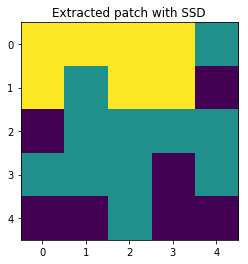

In [11]:
# from sklearn.feature_extraction import image as sk

# SSD
ssd_list = []
# in the left image, corresponding point
ptsC = np.array(ptsL_bad[3]).astype(int)
# print(ptsC)
# only taking the y-values, because that's the height (top of line)
y = ptsC[1] 
# find minimum SSD
for i in range(3,imgL.shape[0]-3):
    # calc ssd
    thisPt = (i,y)
    thisPatch = imgL[thisPt[0]-3:thisPt[0]+2, thisPt[1]-3:thisPt[1]+2] # 5x5 patch
    ssd_sum = np.sum((thisPatch-patch)**2)
    ssd_list.append(ssd_sum)
# put in array so it's not all over the place for printing
ssd_list = np.array(ssd_list)
wholeArraySSD = ssd_list
# print(wholeArraySSD)

# extracted patch with SSD
plt.title("Extracted patch with SSD"),plt.imshow(thisPatch)
plt.show()


### e) Plot SSD values (refer Lecture 14 slide 5). Find the matching point with minimum SSD value. Display found matching points in both the images.

Minimum SSD value: 35


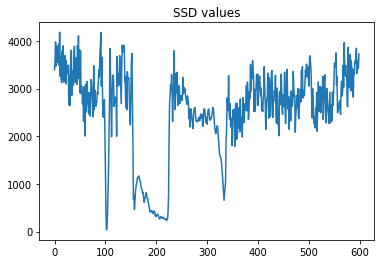

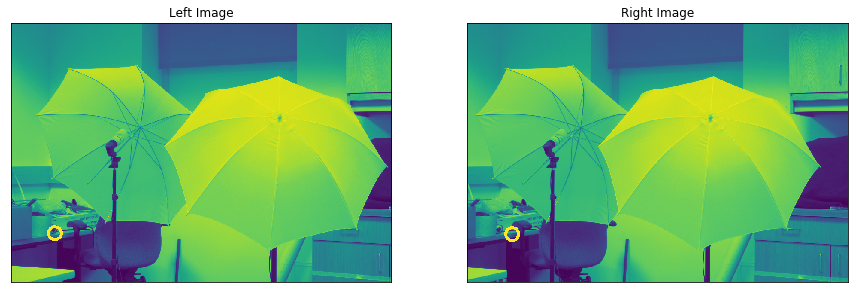

In [12]:
# Minimum SSD Value
lowestPoint = min(wholeArraySSD)
print("Minimum SSD value:", lowestPoint)

# Plot minimum SSD
plt.title("SSD values")
plt.plot(wholeArraySSD)
plt.show()

# --- Display found matching points in both the images ---
thisImgL = imgL.copy() #temp
thisImgR = imgR.copy()
# Return the lowest index (the minimum distance)
lowestPointL = np.argmin(ssd_list)
coords = (lowestPointL,y)

# coords that don't match
rightImageCoords = (xP,yP)

# print(coords)
cv2.circle(thisImgL, coords, 15,(255,255,255),5)
cv2.circle(thisImgR, rightImageCoords, 15,(255,255,255),5)


#   -- END of template mathing use

plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(thisImgL)
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(thisImgR)
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()


### f) Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why.
Yes I found exactly one point on both images, this point corresponds to the lowest SSD. Since the image umbrella is a simple one, there aren't many hardcore textures to match, however, the matching point doesn't seem to be the correct one as the points on both images don't lie on the exact same object. After numerous trials, we can conclude that it isn't the correct one precisely. The images output the lowest point matched using np.argmin which returns the index of the minimum value (the minimum distance on the image)

### g) Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?
If we found multiple matches in the images, then in order to impose a single match we could use constraints such as, reducing the size of the extracted patch, this way we confine the space of finding less matches. Moreover, we can sharpen and smooth the edges out more so that we can detect an accurate minimum matching point in both images that correspond to one another. 

### h) Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?
It's possible that the lowest SSD provides an incorrect match, in that case, to impose a correct one, we need to first identify if the minimum point SSD array is correct, we do this by displaying the entire array with SSD and then iterate over the array to find the most minimum value, once we find that value, that is the SSD we'd use to find the correct match. Also, we can do the same thing as the template_matching assignment (finding waldo) where we are given a template of the point where we'd like to match, reference to that template, and then use <i>cv2.matchTemplate</i> function to find the accurate one. <br>
Finally, instead of finding the best match pairs, we can find all the bf.match pairs and this way we have a larger area to iterate over to find even more minimum values. 